In [1]:
#pip install regressors

In [2]:
import pandas_datareader as wb
from pandas_datareader import data
import yfinance as yf
import requests 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from lxml import html
import datetime
from datetime import datetime
import statsmodels.api as sm
from scipy.stats import norm
from tqdm.notebook import tqdm
import os
from sklearn import linear_model

In [3]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, r2_score
from scipy import stats
#from regressors import stats as st
from sklearn.preprocessing import PolynomialFeatures

In [4]:
def get_treasury_rate():
    
    url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
    r = requests.get(url)
    html = r.text

    soup = BeautifulSoup(html)
    table = soup.find('table', {"class": "t-chart"})
    rows = table.find_all('tr')
    data = []
    for row in rows[1:]:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])

        result = pd.DataFrame(data, columns=['Date', '1 Mo', '2 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'])

    return(result)



def return_df(close_price_df):
        
    return_df = close_price_df.pct_change().apply(lambda x: np.log(1+x))
    
    return return_df

def dummies_beater(all_returns,Rf, option = "return"):
    
    all_returns = all_returns.dropna(how="all")
    Rm = all_returns["SPY"]
    Rm = Rm.fillna(0)
    comps_R = all_returns.drop(columns = ["SPY"])
    comps_R = comps_R.fillna(0)
    
    if option == "return":
        comps_R_excess = comps_R.subtract(Rm.values, axis=0)
        dummies_Return_beaters = comps_R_excess.copy()
        dummies_Return_beaters[dummies_Return_beaters >= 0] =1
        dummies_Return_beaters[dummies_Return_beaters < 0] =0
        
    elif option == "sharpe":
        market_volatility = Rm.std()
        comps_volatility = comps_R.std()
        comps_sharpe = (comps_R - Rf)/comps_volatility
        market_sharpe = (Rm - Rf)/market_volatility
        sharpe_excess = comps_sharpe.subtract(market_sharpe, axis=0)
        dummies_Return_beaters = sharpe_excess.copy()
        dummies_Return_beaters[dummies_Return_beaters >= 0] =1
        dummies_Return_beaters[dummies_Return_beaters < 0] =0
        
    return dummies_Return_beaters

def port_simulation(stock_closed_df):
    
    pct_change_df = stock_closed_df.pct_change()
    ind_er = pct_change_df.mean()
    return_df = pct_change_df.apply(lambda x: np.log(1+x))
    cov_matrix = return_df.cov()
    
    p_ret = [] 
    p_vol = [] 
    p_weights = [] 
    
    
    num_assets = len(stock_closed_df.columns)
    num_portfolios = 10000

    
    for portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er)  
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var)  
        p_vol.append(sd)
    
    data = {'Returns':p_ret, 'Volatility':p_vol}
 
    for counter, symbol in enumerate(stock_closed_df.columns.tolist()):
        data[symbol] = [w[counter] for w in p_weights]
        portfolios  = pd.DataFrame(data)
        
    return portfolios

def portfolios_return_df(equity_selection, all_return):
    
    simulation = port_simulation(equity_selection)
    weight_possibility = simulation.drop(columns=["Returns", "Volatility"])
    portfolio_return_df = pd.DataFrame(columns = weight_possibility.index)
    port_comps_return = all_return[weight_possibility.columns]
    
    for portfolio in tqdm(weight_possibility.index):
        portfolio_return = weight_possibility.iloc[portfolio].mul(port_comps_return).T.sum()
        portfolio_return_df[portfolio] = portfolio_return
    
    return portfolio_return_df


In [5]:
def FF_assign_label(index_comp_info):
        
        
    index_comp_info["bookToMarket"] = 1/index_comp_info["PB_ratio"]
    index_comp_info["Small_Big_Cap"] = index_comp_info["mkt_cap"].map(lambda x: "B" if x >= index_comp_info["mkt_cap"].median() else "S")
    
    lower, upper = index_comp_info["bookToMarket"].quantile([0.3, 0.7])
    index_comp_info["HML_BP"] = index_comp_info["bookToMarket"].map(lambda x: "H" if x >= upper else "M")
    index_comp_info["HML_BP"] = index_comp_info.apply(lambda row: "L" if row["bookToMarket"] <= lower else row["HML_BP"], axis = 1)
    
    lower_roe, upper_roe = index_comp_info["ROE"].quantile([0.3, 0.7])
    index_comp_info["RNW_ROE"] = index_comp_info["ROE"].map(lambda x: "R" if x >= upper_roe else "N")
    index_comp_info["RNW_ROE"] = index_comp_info.apply(lambda row: "W" if row["ROE"] <= lower_roe else row["RNW_ROE"], axis = 1)
    
    lower_invest, upper_invest = index_comp_info["Asset_growth"].quantile([0.3, 0.7])
    index_comp_info["ANC_investment"] = index_comp_info["Asset_growth"].map(lambda x: "A" if x >= upper_invest else "N")
    index_comp_info["ANC_investment"] = index_comp_info.apply(lambda row: "C" if row["Asset_growth"] <= lower_invest else row["ANC_investment"], axis = 1)
            
    return index_comp_info
        
def FF_factor_classifier(index_comp_info_with_label):
        
    data = index_comp_info_with_label
    Small_Low = data.query('(Small_Big_Cap=="S") & (HML_BP=="L")')
    Small_Mid = data.query('(Small_Big_Cap=="S") & (HML_BP=="M")')
    Small_High = data.query('(Small_Big_Cap=="S") & (HML_BP=="H")')
    
    Small_Weak = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="W")')
    Small_Neutral_Profit = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="N")')
    Small_Robust = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="R")')
    
    Small_Conservative =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="C")')
    Small_Neutral_Invest =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="N")')
    Small_Aggresive =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="A")')
    
    Big_Low = data.query('(Small_Big_Cap=="B") & (HML_BP=="L")')
    Big_Mid = data.query('(Small_Big_Cap=="B") & (HML_BP=="M")')
    Big_High = data.query('(Small_Big_Cap=="B") & (HML_BP=="H")')
    
    Big_Weak = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="W")')
    Big_Neutral_Profit = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="N")')
    Big_Robust = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="R")')

    Big_Conservative =  data.query('(Small_Big_Cap=="B") & (ANC_investment=="C")')
    Big_Neutral_Invest = data.query('(Small_Big_Cap=="B") & (ANC_investment=="N")')
    Big_Aggresive =  data.query('(Small_Big_Cap=="B") & (ANC_investment=="A")')
    
    each_groups_list = [Small_Low, Small_Mid, Small_High, 
                            Small_Weak, Small_Neutral_Profit, Small_Robust,
                            Small_Conservative, Small_Neutral_Invest, Small_Aggresive,
                            Big_Low, Big_Mid,Big_High,
                            Big_Weak, Big_Neutral_Profit, Big_Robust,
                            Big_Conservative, Big_Neutral_Invest, Big_Aggresive]
        
    return each_groups_list
    
def FF_classes_return(market_components_return, list_of_group_info, axis=True):
        
    groups_names = ["Small_Low", "Small_Mid", "Small_High",
                        "Small_Weak", "Small_Neutral_Profit", "Small_Robust",
                        "Small_Cons", "Small_Neutral_Invest", "Small_Aggr",
                        "Big_Low", "Big_Mid","Big_High",
                        "Big_Weak", "Big_Neutral_Profit", "Big_Robust",
                        "Big_Cons", "Big_Neutral_Invest", "Big_Aggr"]
    
    df_groups = pd.DataFrame(columns = groups_names)
    
    counter = 0
    
    for group in list_of_group_info:
    
        group_cap = group["mkt_cap"].T
        group_total_cap = group["mkt_cap"].sum()
        group_cap_multi_return = group_cap*market_components_return[list(group.index)]
        
        if axis == True:
            df_groups[groups_names[counter]] = group_cap_multi_return.apply(lambda row: row.sum()/group_total_cap, axis=1)
        
        else:
            groups_index_return = group_cap_multi_return.sum()/group_total_cap
            df_groups[groups_names[counter]] = [groups_index_return]
    
        counter += 1
                
    return df_groups
    
def FF_calc_factors(classes_return_df, df = True):
    
    factor_name = ["SMB", "HML", "RMW", "CMA"]
    
    SMB_BP = (classes_return_df["Small_Low"] + classes_return_df["Small_Mid"] 
                      + classes_return_df["Small_High"]) - (classes_return_df["Big_Low"]
                      + classes_return_df["Big_Mid"] + classes_return_df["Big_High"])/3
    
    SMB_PFT = (classes_return_df["Small_Weak"] + classes_return_df["Small_Neutral_Profit"] 
                      + classes_return_df["Small_Robust"]) - (classes_return_df["Big_Weak"]
                      + classes_return_df["Big_Neutral_Profit"] + classes_return_df["Big_Robust"])/3
    
    SMB_INV = (classes_return_df["Small_Cons"] + classes_return_df["Small_Neutral_Invest"] 
                      + classes_return_df["Small_Aggr"]) - (classes_return_df["Big_Cons"]
                      + classes_return_df["Big_Neutral_Invest"] + classes_return_df["Big_Aggr"])/3
    
    if df == True:
        
        FF_factors_data = pd.DataFrame(columns = factor_name)
        
    
    FF_factors_data["SMB"] = (SMB_BP + SMB_PFT + SMB_INV)/3
    
    FF_factors_data["HML"] = (classes_return_df["Small_High"] + classes_return_df["Big_High"]
                      - (classes_return_df["Small_Low"] + classes_return_df["Big_Low"])) / 2
    
    FF_factors_data["RMW"] = (classes_return_df["Small_Robust"] + classes_return_df["Big_Robust"]
                      - (classes_return_df["Small_Weak"] + classes_return_df["Big_Weak"])) / 2
    
    FF_factors_data["CMA"] = (classes_return_df["Small_Cons"] + classes_return_df["Big_Cons"]
                      - (classes_return_df["Small_Aggr"] + classes_return_df["Big_Aggr"])) / 2
        
    return FF_factors_data

    
def FF_regress(FF_factors_df, target_comp_risk_premium, modelType = 'linear', transform = False):
           
    y = target_comp_risk_premium
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly_X = poly.fit_transform(FF_factors_df)
    poly_FF = pd.DataFrame(data = poly_X,index=FF_factors_df.index)
        
    if modelType == 'lasso':
        
        X = poly_FF
        
        model = linear_model.Lasso(alpha = 0.00000001)
        model.fit(X.astype(float), y.astype(float))
        params = np.append(model.intercept_,model.coef_)
        predictions = model.predict(X)
        
    elif modelType == 'linear':
        
        if transform == True:
            X = poly_FF
        
        elif transform == False:
            X = FF_factors_df
            
        model = linear_model.LinearRegression()
        model.fit(X.astype(float), y.astype(float))
        params = np.append(model.intercept_,model.coef_)
        predictions = model.predict(X)
        
    elif modelType == 'ridge':
    
        if transform == True:
            X = poly_FF
            set_alphas=[0.000001,0.0000001]
            
        elif transform == False:
            X = FF_factors_df
            set_alphas = [0.00000001,0.0000001]
            
        model = linear_model.RidgeCV(alphas = set_alphas, cv=5)
        model.fit(X.astype(float), y.astype(float))
        params = np.append(model.intercept_,model.coef_)
        predictions = model.predict(X)
        
    elif modelType == 'elastic':
        
        if transform == True:
            X = poly_FF
            set_alphas = [0.000001,0.0000001]
        
        elif transform == False:
            X = FF_factors_df
            set_alphas = [0.00000001,0.0000001]
            
        model = linear_model.ElasticNetCV(alphas = set_alphas, cv=5, random_state=0)
        model.fit(X.astype(float), y.astype(float))
        params = np.append(model.intercept_,model.coef_)
        predictions = model.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X.reset_index(drop=True)))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b
    
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(X.columns)))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard_Errors"],myDF3["t_stat"],myDF3["P_value"] = [params,sd_b,ts_b,p_values]
    R2 = r2_score(y,predictions)

    return myDF3 , R2

def regressAll(FF_factors, all_returns, days, train_base=2000, Rf=0.000001, modelType = 'linear', transform=False):
    

    dummies_Return_beaters = dummies_beater(all_returns, Rf)

    prob_10obs = dummies_Return_beaters.iloc[days - 10 : days].mean().T
    prob_20obs = dummies_Return_beaters.iloc[days - 20 : days].mean().T
    prob_30obs = dummies_Return_beaters.iloc[days - 30 : days].mean().T

    target = dummies_Return_beaters.iloc[days+1]
    
    if modelType == "lasso":
        transform = True

    if transform == True:
        features_df = pd.DataFrame(columns = ["const",'B1', 'B2', 'B3', 'B4', 'B5'
                                              ,'B6', 'B7', 'B8', 'B9', 'B10',"B11"
                                              ,"B12","B13","B14","B15"
                                              ,"Pval_C", "Pval1", "Pval2", "Pval3", "Pval4", "Pval5"
                                              ,"Pval6", "Pval7", "Pval8", "Pval9", "Pval10", "Pval11"
                                              ,"Pval12","Pval13", "Pval14","Pval15"
                                              , 'R2'],
                               index = all_returns.columns)
        
    else:    
        features_df = pd.DataFrame(columns = ["const",'B1', 'B2', 'B3', 'B4', 'B5',"Pval_C", "Pval1", "Pval2", "Pval3", "Pval4", "Pval5", 'R2'],
                               index = all_returns.columns)

    comps_R = all_returns.drop(columns = ["SPY"]).fillna(0)
    FF_factors = FF_factors.fillna(0)
    for i in comps_R:

        regression_stat, R2 = FF_regress(FF_factors.iloc[days-train_base:days], comps_R[i].iloc[days-train_base:days], modelType, transform)
        betas = list(regression_stat["Coefficients"])
        Pvals = list(regression_stat["P_value"])
        features = betas + Pvals
        features.append(R2)
        features_df.loc[i] = features

    features_df["prob_10obs"], features_df["prob_20obs"], features_df["prob_30obs"] = [prob_10obs, prob_20obs, prob_30obs]
    features_df["true_target"] = target

    return features_df
    



    

# Data Collection

In [6]:
#print(os.getcwd())
#print(os.listdir(os.getcwd()))

In [7]:
FF_info = pd.read_csv("Fama_French_info.csv", index_col = 0)

In [11]:
#use below link to download 2min data we use in the project
link = "https://drive.google.com/file/d/1-sHk__G9d3rz5FY7-T6B5ZqRJdmzoKvH/view?usp=sharing"

In [12]:
#code for downloading sp500 stock price data
str1 = ' '
index_list = FF_info.index.tolist()
index_list.append("SPY")
#index_list.reverse()
total_string = str1.join(index_list)
#SPYn500_2m_df = yf.download(total_string, start = , end = , interval = '2m')

In [13]:
sp_2m_close = pd.read_csv("SPYn500_2m_close.csv", index_col = 0)
#sp_30m_close = pd.read_csv("data/SPYn500_30m_close.csv", index_col = 0)

In [14]:
sp_2m_close.iloc[:3]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-11 09:30:00-04:00,150.729996,20.120001,214.000000,141.949997,111.199997,120.519997,333.580200,118.260002,324.829987,571.551025,...,61.740002,154.020004,62.622299,58.139999,121.169998,123.730003,146.309998,492.0,64.209999,196.289993
2021-10-11 09:32:00-04:00,150.690002,20.020000,213.889999,142.850006,111.160004,121.260002,333.104889,118.154999,325.119995,574.900024,...,62.064999,155.339996,62.560001,58.119999,121.239998,123.787201,146.315002,NaN,63.900002,196.509995
2021-10-11 09:34:00-04:00,151.330002,19.870001,214.000000,142.889999,111.129997,121.184998,335.989990,118.599998,324.910004,575.900024,...,62.360001,155.895004,62.556599,58.000000,120.980003,123.180000,NaN,NaN,63.650002,196.820007


# Calculate log-return (assuming return is log-normal) for both time interval

In [15]:
total_2m_return = return_df(sp_2m_close)
#total_30m_return = return_df(sp_30m_close)

In [16]:
#First row is always NaN
total_2m_return = total_2m_return.dropna(how = "all")

In [17]:
#Fill NaN with 0 in return df because NaN value represent a number too close to 0
total_2m_return = total_2m_return.fillna(0)

In [18]:
total_2m_return.iloc[:3]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-11 09:32:00-04:00,-0.000265,-0.004983,-0.000514,0.006320,-0.000360,0.006121,-0.001426,-0.000888,0.000892,0.005842,...,0.005250,0.008534,-0.000995,-0.000344,0.000578,0.000462,0.000034,0.000000,-0.00484,0.001120
2021-10-11 09:34:00-04:00,0.004238,-0.007521,0.000514,0.000280,-0.000270,-0.000619,0.008624,0.003759,-0.000646,0.001738,...,0.004742,0.003566,-0.000054,-0.002067,-0.002147,-0.004917,0.000000,0.000000,-0.00392,0.001576
2021-10-11 09:36:00-04:00,-0.004039,0.002789,-0.000187,-0.001891,0.000315,0.003336,0.000000,-0.003886,0.000062,-0.001808,...,-0.000802,0.000673,0.003406,-0.001035,0.001280,0.000244,0.001264,0.002923,0.00157,-0.000762


# Defining components return, market return, dummies beater

In [19]:
sp500_2m_return = total_2m_return.drop(columns=["SPY"]) #seperate market ETF from other companies

In [20]:
Rm_2m = total_2m_return[['SPY']]
#need to discount Monthly Rf to 2m Rf using yield curve(continuously compounded) when doing real time analysis
Rf = 0.000001

In [21]:
dummies_2m_beater = dummies_beater(total_2m_return, Rf, option="sharpe")

In [22]:
dummies_2m_beater.iloc[:3]

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-10-11 09:32:00-04:00,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-10-11 09:34:00-04:00,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
2021-10-11 09:36:00-04:00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


# Feature Engineering

## Calculate FF factors

In [23]:
FF_info_labeled = FF_assign_label(FF_info)
FF_classified_list = FF_factor_classifier(FF_info_labeled)
FF_2m_classes_return = FF_classes_return(sp500_2m_return,FF_classified_list)
FF_2m_factor = FF_calc_factors(FF_2m_classes_return)
FF_2m_factor["Rm-Rf"] = Rm_2m - Rf

In [24]:
# fill NaN with 0 for FF factors because the value is too small
FF_2m_factor = FF_2m_factor.fillna(0)

In [25]:
FF_2m_factor.iloc[:3]

,SMB,HML,RMW,CMA,Rm-Rf
Datetime,,,,,
2021-10-11 09:32:00-04:00,-0.001462,-0.003179,0.001835,-0.000872,0.001503
2021-10-11 09:34:00-04:00,-0.005193,-0.002111,0.001227,-0.000469,-0.001025
2021-10-11 09:36:00-04:00,0.004055,0.001614,-0.001921,0.001213,0.000136


## Calculate features and relevant statistic for given company 

Because of multi-collinearity between FF factors, we need to incorporate models like ridge regression and elastic net into parameters estimation process. 

In [26]:
#Default argument is linear model without polynimio features 
FF_regress(FF_2m_factor, sp500_2m_return["AAPL"]-Rf)

(   Coefficients  Standard_Errors  t_stat  P_value
 0        0.0000            0.000   0.325    0.745
 1       -0.3181            0.012 -27.625    0.000
 2       -0.4702            0.022 -21.836    0.000
 3        0.6130            0.024  25.983    0.000
 4        1.4745            0.030  49.395    0.000
 5        1.6016            0.027  59.135    0.000,
 0.5610279415110841)

In [27]:
#other regression models can be used by specifing in argument; modelType is for model selection and transform is for polynomio feature transformation
FF_regress(FF_2m_factor, sp500_2m_return["AAPL"]-Rf, modelType="ridge", transform = True)

(    Coefficients  Standard_Errors  t_stat  P_value
 0         0.0000            0.000   0.391    0.696
 1        -0.3057            0.012 -25.817    0.000
 2        -0.4700            0.023 -20.178    0.000
 3         0.5877            0.027  21.563    0.000
 4         1.3688            0.034  40.837    0.000
 5         1.6059            0.027  58.914    0.000
 6        10.0791           10.604   0.950    0.342
 7         0.7609           13.778   0.055    0.956
 8        11.1005           16.400   0.677    0.499
 9        -8.8915            4.051  -2.195    0.028
 10        0.9623           20.723   0.046    0.963
 11       -5.5943           11.254  -0.497    0.619
 12        6.8146           26.527   0.257    0.797
 13        1.1029           16.183   0.068    0.946
 14       -1.0358           44.089  -0.023    0.981
 15        6.0549           40.793   0.148    0.882,
 0.5948224015386481)

# Time Series model construction

  0%|          | 0/1000 [00:00<?, ?it/s]

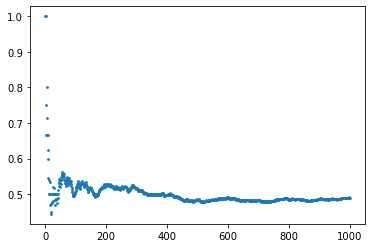

In [28]:
time_length = range(len(dummies_2m_beater.index[:1000]))
winner_rate_list = []
for length in tqdm(time_length):
    winner_rate = dummies_2m_beater["AAPL"].iloc[:length].mean()
    winner_rate_list.append(winner_rate)
    
plt.scatter(time_length, winner_rate_list, s=3)

Our goal is to predict wheather a given security or portfolio will outperform the market in the next trading period, so we estimate factor exposure based on a given amount of most recent observations at T0 and use the exposures+relevant statistic to predict the outcome at T1. Since the probability of beating the market will converge to 0.5 as observation increase, we also include realized probabilities that are observe from last 10, 20, and 30 observations as features. We will roll the model and make prediction for at least 10 trading period, and will collect accuracy metrics of time-series prediction.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

In [46]:
def performence_df(FF_2m_factor,total_2m_return, Rf, modelType = "linear", transform = False):

    performence = pd.DataFrame(columns=["precision", "recall", "f1"])

    days = 150

    while days < 152:
        #split
        data = regressAll(FF_2m_factor,total_2m_return,days,train_base = 150,Rf = Rf, modelType = modelType, transform = transform)
        data = data.fillna(0)
        split = int(len(data)*0.6)
        training_set = data.iloc[:split]
        testing_set = data.iloc[split:]
        
        sgd_clf = SGDClassifier(random_state = 42,loss = 'modified_huber')
        model1 = sgd_clf.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        log_clf = LogisticRegression(solver="lbfgs", random_state=42)
        rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
        svm_clf = SVC(gamma="scale", random_state=42, probability=True)
        model2 = log_clf.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        model3 = rnd_clf.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        model4 = svm_clf.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        voting_clf = VotingClassifier(
        estimators=[('sgd',sgd_clf),('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft')
        final_model = voting_clf.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
    
        prediction = final_model.predict(testing_set.drop(columns=["true_target"]))
        testing_set = testing_set.copy()
        testing_set["prediction"] = prediction
        
        precision = precision_score(testing_set["true_target"], testing_set["prediction"])
        recall = recall_score(testing_set["true_target"], testing_set["prediction"])
        f1 = f1_score(testing_set["true_target"], testing_set["prediction"])
    
        score_series = pd.Series([precision, recall, f1], index = performence.columns)
        performence = performence.append(score_series, ignore_index=True)
    
        days += 1
    
    return performence

In [69]:
def performence_df(FF_2m_factor,total_2m_return, Rf, modelType = "linear", transform = False):

    performence = pd.DataFrame(columns=["precision", "recall", "f1"])

    days = 150

    while days < 160:
        #split
        data = regressAll(FF_2m_factor,total_2m_return,days,train_base = 150,Rf = Rf, modelType = modelType, transform = transform)
        data = data.fillna(0)
        split = int(len(data)*0.6)
        training_set = data.iloc[:split]
        testing_set = data.iloc[split:]
        
        sgd_clf = SGDClassifier(random_state = 42,loss = 'modified_huber')
        model1 = sgd_clf.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        log_clf = LogisticRegression(solver="lbfgs", random_state=42)
        rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
        svm_clf = SVC(gamma="scale", random_state=42, probability=True)
        model1 = sgd_clf.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        model2 = log_clf.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        model3 = rnd_clf.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        model4 = svm_clf.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        
        bag_clf1 = BaggingClassifier(SGDClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
        model5 = bag_clf1.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        y_pred1 = bag_clf1.predict(testing_set.drop(columns=["true_target"]))
        
        bag_clf2 = BaggingClassifier(LogisticRegression(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
        model6 = bag_clf2.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        y_pred2 = bag_clf1.predict(testing_set.drop(columns=["true_target"]))
        
        bag_clf3 = BaggingClassifier(RandomForestClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
        model7 = bag_clf3.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        y_pred3 = bag_clf3.predict(testing_set.drop(columns=["true_target"]))
        
        bag_clf4 = BaggingClassifier(SVC(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
        model8 = bag_clf4.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        y_pred4 = bag_clf4.predict(testing_set.drop(columns=["true_target"]))
        
        
        voting_clf1 = VotingClassifier(
        estimators=[('sgd',sgd_clf),('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='soft')
        final_model = voting_clf1.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        
        voting_clf2 = VotingClassifier(
        estimators=[('bag1', model5),('bag2', model6), ('bag3', model7), ('bag4', model8)],
        voting='soft')
        final = voting_clf2.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
        
        voting_clf_final = VotingClassifier(
        estimators=[('first', voting_clf1),('second', voting_clf2)],
        voting='soft')
        real_final_model = voting_clf_final.fit(training_set.drop(columns=["true_target"]),training_set["true_target"])
    
        prediction = final.predict(testing_set.drop(columns=["true_target"]))
        testing_set = testing_set.copy()
        testing_set["prediction"] = prediction
        
        precision = precision_score(testing_set["true_target"], testing_set["prediction"])
        recall = recall_score(testing_set["true_target"], testing_set["prediction"])
        f1 = f1_score(testing_set["true_target"], testing_set["prediction"])
    
        score_series = pd.Series([precision, recall, f1], index = performence.columns)
        performence = performence.append(score_series, ignore_index=True)
    
        days += 1
    
    return performence

In [70]:
p1 = performence_df(FF_2m_factor,total_2m_return, Rf=Rf)

In [71]:
p1.mean()

precision    0.710744
recall       0.716667
f1           0.713693
dtype: float64

In [ ]:
p2 = performence_df(FF_2m_factor,total_2m_return, Rf=Rf, modelType="lasso")

In [ ]:
p2.mean()

In [ ]:
p3 = performence_df(FF_2m_factor,total_2m_return, Rf=Rf, modelType="elastic", transform=False)

In [ ]:
p3.mean()

In [ ]:
p4 = performence_df(FF_2m_factor,total_2m_return, Rf=Rf, modelType="ridge")

In [ ]:
p4.mean()

In [ ]:
p5 =  performence_df(FF_2m_factor,total_2m_return, Rf=Rf, modelType="ridge", transform=True)

In [ ]:
p5.mean()

In [ ]:
p6 = performence_df(FF_2m_factor,total_2m_return, Rf=Rf, modelType="linear", transform=True)

In [ ]:
p6.mean()